In [1]:
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from fbprophet import Prophet
from bayes_opt import BayesianOptimization

random.seed(42)
np.random.seed(42)

Importing plotly failed. Interactive plots will not work.


# Bayesian Optimisation of Prophet Hyperparameters

This notebook illustrates optimisation of continuous hyperparamaters of prophet models using the 
[BayesianOptimization](https://github.com/fmfn/BayesianOptimization) package.

The notebook is organised into the following sections:
 * Importing Data
 * Building Simple Model
 * Cross-validating Model
 * Tuning Discrete Prophet Hyperparameters
 * Bayesian Optimisation of Continuous Prophet Hyperparameters
 * Conclusion


## Import Data

Data has been cleaned but may still have issues.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in my [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.

The `y` variable is temperature * 10.  I'm primarily interested in very short term forecasts (less than 2 hours)
but forecasts over 24 hours are also interesting.

In [2]:
df = pd.read_csv("../data/CamUKWeather.csv", parse_dates=True)
print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
df

Shape:
(192885, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192885 entries, 0 to 192884
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ds                 192885 non-null  object
 1   year               192885 non-null  int64 
 2   doy                192885 non-null  int64 
 3   time               192885 non-null  object
 4   y                  192885 non-null  int64 
 5   humidity           192885 non-null  int64 
 6   dew.point          192885 non-null  int64 
 7   pressure           192885 non-null  int64 
 8   wind.speed.mean    192885 non-null  int64 
 9   wind.bearing.mean  192885 non-null  int64 
 10  wind.speed.max     192885 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 16.2+ MB
None

Summary stats:


,year,doy,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
count,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000
mean,2013.895803,186.882298,101.096819,79.239951,62.135174,1014.404153,44.588148,196.223423,117.140369
std,3.283992,106.486420,64.465602,16.908724,51.016879,11.823922,40.025546,82.458390,80.116199
min,2008.000000,1.000000,-138.000000,25.000000,-143.000000,963.000000,0.000000,0.000000,0.000000
25%,2011.000000,94.000000,52.000000,69.000000,25.000000,1008.000000,12.000000,135.000000,60.000000
50%,2014.000000,191.000000,100.000000,83.000000,64.000000,1016.000000,35.000000,225.000000,100.000000
75%,2017.000000,280.000000,145.000000,92.000000,100.000000,1023.000000,67.000000,270.000000,160.000000
max,2020.000000,366.000000,361.000000,100.000000,216.000000,1048.000000,291.000000,315.000000,580.000000



Raw data:


,ds,year,doy,time,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
0,2008-08-01 08:30:00,2008,214,09:30:00,186,69,128,1010,123,180,280
1,2008-08-01 09:00:00,2008,214,10:00:00,191,70,135,1010,137,180,260
2,2008-08-01 09:30:00,2008,214,10:30:00,195,68,134,1010,133,180,260
3,2008-08-01 10:00:00,2008,214,11:00:00,200,68,139,1010,129,180,240
4,2008-08-01 10:30:00,2008,214,11:30:00,213,61,135,1010,145,180,260
...,...,...,...,...,...,...,...,...,...,...,...
192880,2020-01-16 00:00:00,2020,16,00:00:00,40,78,5,1017,45,180,100
192881,2020-01-16 00:30:00,2020,16,00:30:00,36,86,15,1018,25,180,120
192882,2020-01-16 01:00:00,2020,16,01:00:00,36,85,13,1018,28,180,80
192883,2020-01-16 01:30:00,2020,16,01:30:00,36,82,8,1018,17,180,80


Create train and test data.  Will perform [rolling origin forecasting](https://otexts.com/fpp2/accuracy.html#time-series-cross-validation) later.

In [3]:
threshold = 2019
df_test  = df[df['year'] >= threshold]
df_train = df[df['year'] <  threshold]

---


## Build Simple Model

First, start by building a simple model with flat growth and no weekly seasonality.  This is a quick sanity check.  Results should be similar to my previous R version.

One reason for using the python prophet version over R is to check the 
[flat growth](https://facebook.github.io/prophet/docs/additional_topics.html#flat-trend-and-custom-trends)
option, (only available in python), with 
[linear and logistic growth I used earlier in R](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/4.02-prophet.R).

Seasonality mode defaults to additive for both daily and yearly.  Yearly seasonality is set to use 2 Fourier terms to enforce smooth annual cyclicality.  Yearly seasonality shows over-fitting if `yearly_seasonality='auto'` is used.
It _may_ be better to use `yearly_seasonality='auto'` and tune `seasonality_prior_scale` instead of setting the number of Fourier terms.

In [4]:
m = Prophet(growth='flat',
            daily_seasonality=True,
            weekly_seasonality=False,
            yearly_seasonality=2)
m.fit(df_train);

### Make forecast

Use `df_test` data created earlier to make forecast.  `df_test` contains data in 2019 and after.
`yhat_lower` and `yhat_upper` are the 80% uncertainty intervals.

In [5]:
forecast = m.predict(df_test)
pd.concat([forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().reset_index(drop=True), 
           df_test['y'].tail().reset_index(drop=True)], axis=1)

,ds,yhat,yhat_lower,yhat_upper,y
0,2020-01-16 00:00:00,17.667960,-29.847775,62.817637,40
1,2020-01-16 00:30:00,16.180201,-29.955690,60.990527,36
2,2020-01-16 01:00:00,14.807732,-31.797248,64.647189,36
3,2020-01-16 01:30:00,13.508647,-32.661017,61.800024,36
4,2020-01-16 02:00:00,12.256809,-31.535405,59.283150,36


### Plot forecast

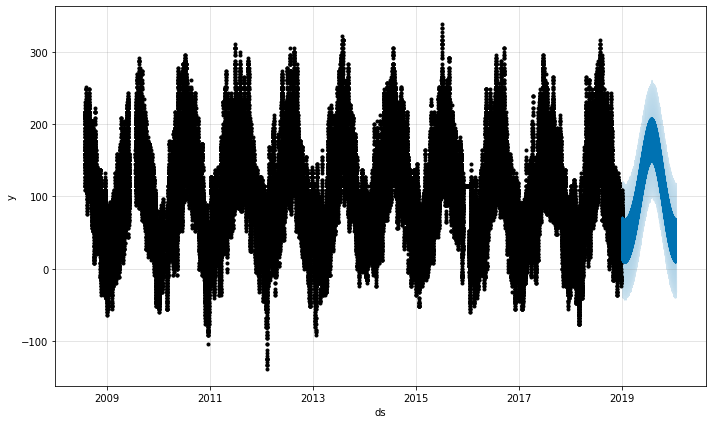

In [6]:
fig1 = m.plot(forecast)

### Plot components of simple model forecast

As expected the trend is flat and is close to the mean `y` (temperature in C * 10) value from `df.describe()` above (101.93).

The seasonalities are smoothly varying and cyclic.
The daily and yearly seasonalities resemble the 
[seasonalities obtained with R](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Seasonality).

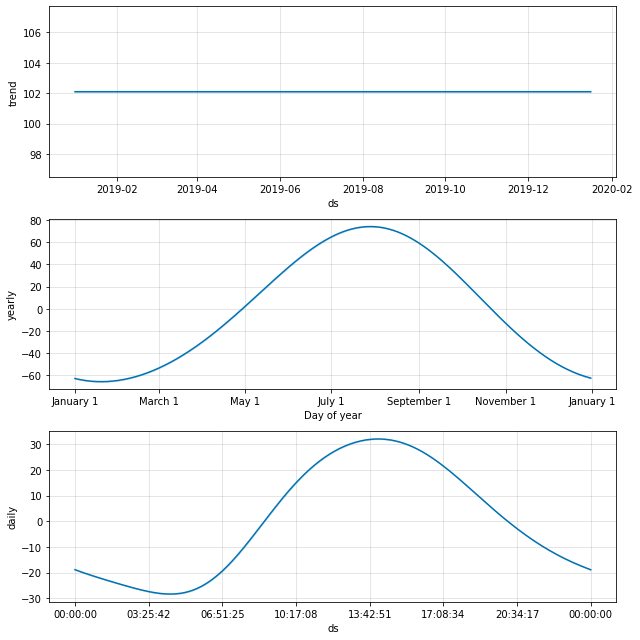

In [7]:
fig2 = m.plot_components(forecast)

---

## Cross-validate Model

Second, cross-validate the simple model to get some indication of performance.

To perform [rolling origin forecasting](https://otexts.com/fpp2/accuracy.html#time-series-cross-validation) first build a prophet model on `df` instead of `df_train`.  
Then run cross-validation on a horizon of 1 hour, starting with 90000 hours (over 10 years) of training data in the first cutoff and then making predictions every 1000 hours. On this 11 year time series, this corresponds to 11 total forecasts between 2018-11-25 09:00:00 and 2020-01-16 01:00:00.  This is a small validation set.

I'm primarily interested in making "nowcasts" (forecasts in the next 1 to 2 hours) because I live very close to the data source and the UK met office only update the forecasts on their web site every 2 hours. 

In [8]:
from fbprophet.diagnostics import cross_validation, performance_metrics

m = Prophet(growth='flat',
            daily_seasonality=True,
            weekly_seasonality=False,
            yearly_seasonality=2)
m.fit(df)

df_cv = cross_validation(m,                                                  
                         initial='90000 hours',
                         period='1000 hours',
                         horizon='1 hours')
df_cv

INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-25 09:30:00,69.739130,19.884369,117.277538,40,2018-11-25 09:00:00
1,2018-11-25 10:00:00,74.736026,26.711922,122.259926,44,2018-11-25 09:00:00
2,2019-01-06 01:30:00,14.903101,-29.389721,59.957277,32,2019-01-06 01:00:00
3,2019-01-06 02:00:00,13.648006,-28.144470,58.607385,32,2019-01-06 01:00:00
4,2019-02-16 17:30:00,60.864809,16.395474,109.247482,92,2019-02-16 17:00:00
5,2019-02-16 18:00:00,57.318057,13.104304,104.092568,88,2019-02-16 17:00:00
6,2019-03-30 09:30:00,78.062718,31.079447,124.812803,123,2019-03-30 09:00:00
7,2019-03-30 10:00:00,83.093376,35.050668,129.022228,141,2019-03-30 09:00:00
8,2019-05-11 01:30:00,91.757079,46.765174,135.244288,56,2019-05-11 01:00:00
9,2019-05-11 02:00:00,90.536030,44.309768,139.393141,56,2019-05-11 01:00:00


In [9]:
df_p = performance_metrics(df_cv)
df_p[['horizon','rmse','mae','mape']]

,horizon,rmse,mae,mape
0,00:30:00,30.129179,26.998845,0.710990
1,01:00:00,31.161329,27.206752,0.554322


These metrics are comparable to the basic linear and logistic model results previously obtained in R.

---


## Tune Discrete Prophet Hyperparameters

Third, tune the categorical parameters.

In general, Gaussian process-based Bayesian optimisation does not support discrete parameters.  Discrete parameters should probably be tuned before continuous parameters.

I previously added two additional regressors:
 * dew point
 * humidity

Dew point is temperature to which air must be cooled to become saturated with water vapor, and
humdidity is atmospheric moisture.

These discrete hyperparameters were tuned:
 * growth
 * daily seasonality mode
 * yearly seasonality mode
 * dew point mode
 * humidity mode
 
Final hyperparameters from 
[R version](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/4.02-prophet.R):
```R
params <- data.frame(growth='linear',
                     n.changepoints=0,
                     daily.mode='multiplicative',
                     yearly.mode='additive',
                     daily.fo=2,
                     yearly.fo=2,
                     daily.prior=0.01,
                     yearly.prior=0.01,
                     dp.mode='multiplicative',
                     hum.mode='multiplicative',
                     dp.prior=0.01,
                     hum.prior=0.01,
                     stringsAsFactors=FALSE)
```

When setting `n.changepoints=0` the trend often showed small amounts of postive or negative growth.

The seasonality and regressor priors were tuned over a small range of values \[0.01, 0.1, 1, 10\].
The low number of Fourier terms and low prior values results in the seasonality components being dominated by the regressors.  This suggests the seasonality is not useful for such short-term forecasts.
It will be interesting to see at what horizon seasonality becomes less dominated.  Alternatively, the tuning grid could be extended to 100 or higher.

Nonetheless, these parameters give much improved results compared to the simple model above.

| horizon  | rmse     | mae      | mape     |
|----------|----------|----------|----------|
| 00:30:00 | 6.784561 | 5.127664 | 0.069588 |
| 01:00:00 | 8.080058 | 5.304410 | 0.076183 |

I won't translate the R code to python.  See the [prophet docs](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)
for a python grid search example.

---


## Bayesian Optimisation of Continuous Prophet Hyperparameters

Fourth, tune the continuous parameters.

Below I give an example of Bayesian optimisation of seasonality and regressor parameters.

These continuous parameters are optimised:
 * daily_prior_scale
 * yearly_prior_scale
 * dew point prior scale
 * humidity prior scale
 
The python [BayesianOptimization](https://github.com/fmfn/BayesianOptimization)
library is used.  It is an implementation of constrained global optimization with Gaussian processes.

Next, I define the prophet model to optimise.

In [10]:
def prophet_f(daily_prior, yearly_prior, hum_prior, dp_prior, metric='rmse', period='1000 hours'):
    """
    Implements the prophet model to be optimised and performs cross-validation
    
    Args:
        daily_prior:  daily seasonality prior scale
        yearly_prior: yearly seasonality prior scale
        hum_prior:    humidity regressor prior scale 
        dp_prior:     dew.point regressor prior scale

    Returns:
        negative of root mean square error
    """
                     
    m = Prophet(growth='flat',
                weekly_seasonality=False)
    
    m.add_seasonality(name='daily',
                      period=1,
                      fourier_order=2,
                      mode='multiplicative',
                      prior_scale=10 ** daily_prior)
    m.add_seasonality(name='yearly',
                      period=365.25,
                      fourier_order=2,
                      mode='additive',
                      prior_scale=10 ** yearly_prior)
    
    m.add_regressor('humidity',
                    mode='multiplicative',
                    prior_scale=10 ** hum_prior)
    m.add_regressor('dew.point',
                    mode='multiplicative',
                    prior_scale=10 ** dp_prior)
    
    m.fit(df)
    df_cv = cross_validation(m,                                                  
                             initial='90000 hours',
                             period=period,
                             horizon='1 hours')
    
    if metric == 'rmse':
        df_cv_rmse = ((df_cv.y - df_cv.yhat) ** 2).mean() ** .5
        return - df_cv_rmse
    else:
        df_p = performance_metrics(df_cv)
        return m, df_p[['horizon','rmse','mae','mape']]
    

**WARNING** Next cell may take quite a while to run.

Run time can be reduced by 
 * decreasing `init_points` and/or `n_iter` in the `optimizer.maximize` call below
 or
 * increasing `period` (up to maximum of '15000 hours') in the `cross_validation` call in the `prophet_f` function above.
 
**NOTE** It may be necessary to scroll down through the runtime messages to find the optimised parameters.
Or, set `verbose=0` in the `BayesianOptimization` call below.

In [11]:
# daily_prior_scale calculated as 10 ** daily_prior in prophet_f
pbounds = {'daily_prior': (-2, 2), 'yearly_prior': (-2, 2),
           'hum_prior':   (-2, 2), 'dp_prior':     (-2, 2)}

optimizer = BayesianOptimization(
    f=prophet_f,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1
)

optimizer.maximize(
    init_points=10,
    n_iter=10)

print("\nMax params:")
print(optimizer.max)


|   iter    |  target   | daily_... | dp_prior  | hum_prior | yearly... |
-------------------------------------------------------------------------


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  1        | -5.892    | -0.3319   |  0.8813   | -2.0      | -0.7907   |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  2        | -5.894    | -1.413    | -1.631    | -1.255    | -0.6178   |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  3        | -5.896    | -0.4129   |  0.1553   | -0.3232   |  0.7409   |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  4        | -5.893    | -1.182    |  1.512    | -1.89     |  0.6819   |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  5        | -5.896    | -0.3308   |  0.2348   | -1.438    | -1.208    |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  6        | -5.896    |  1.203    |  1.873    | -0.7463   |  0.7693   |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  7        | -5.895    |  1.506    |  1.578    | -1.66     | -1.844    |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  8        | -5.896    | -1.321    |  1.513    | -1.607    | -0.3156   |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  9        | -5.896    |  1.832    |  0.1327   |  0.7675   | -0.7379   |


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  10       | -5.893    |  0.746    |  1.339    | -1.927    |  1.001    |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  11       | -5.896    | -1.969    | -1.353    |  0.8375   |  1.059    |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  12       | -5.896    | -0.2298   | -0.3461   |  0.1912   |  0.9768   |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  13       | -5.896    |  0.4935   | -1.107    |  1.836    |  1.219    |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  14       | -5.896    | -1.915    |  1.232    |  1.859    |  0.8083   |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  15       | -5.891    | -0.5423   | -1.91     | -1.39     |  1.886    |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  16       | -5.892    | -0.2874   |  0.8332   | -1.989    | -0.8146   |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  17       | -5.886    | -0.3065   | -2.0      | -1.753    |  2.0      |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  18       | -5.885    | -0.1552   | -1.97     | -1.977    |  1.861    |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  19       | -5.883    |  0.4908   | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  20       | -5.883    |  1.768    | -2.0      | -2.0      |  2.0      |

Max params:
{'target': -5.883217196442895, 'params': {'daily_prior': 0.4908015707468804, 'dp_prior': -2.0, 'hum_prior': -2.0, 'yearly_prior': 2.0}}


`yearly_prior` has converged to the maximum limit (2), `dp_prior` and `hum_prior` have converged to the minimum limit (-2).
Anecdotally, it seemed like the Bayesian optimisation was bouncing around in a shallow basin.
`daily_prior` may or may not have converged.  We can check by setting new bounds to optimise only `daily_prior`.

In [13]:
# daily_prior_scale calculated as 10 ** daily_prior in prophet_f
pbounds_red = {'daily_prior': (-2, 2), 'yearly_prior': (2, 2),
               'hum_prior':   (-2, -2),    'dp_prior': (-2, -2)}

optimizer.set_bounds(new_bounds=pbounds_red)

optimizer.maximize(
    init_points=0,
    n_iter=10)

print("\nMax params:")
print(optimizer.max)


|   iter    |  target   | daily_... | dp_prior  | hum_prior | yearly... |
-------------------------------------------------------------------------
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  21       | -5.883    |  1.186    | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  22       | -5.883    |  2.0      | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  23       | -5.883    |  0.7832   | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  24       | -5.883    | -2.0      | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  25       | -5.883    | -1.364    | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  26       | -5.883    | -1.708    | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  27       | -5.883    |  0.6975   | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  28       | -5.883    |  0.879    | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  29       | -5.883    | -0.7728   | -2.0      | -2.0      |  2.0      |
bounds: 
[[-2.  2.]
 [-2. -2.]
 [-2. -2.]
 [ 2.  2.]]


/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.p

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-11-25 09:00:00 and 2020-01-16 01:00:00



|  30       | -5.884    |  0.09288  | -2.0      | -2.0      |  2.0      |

Max params:
{'target': -5.8830215248022, 'params': {'daily_prior': 0.7832480635982564, 'dp_prior': -2.0, 'hum_prior': -2.0, 'yearly_prior': 2.0}}


### Compare optimised model with earlier models

There was a marginal improvement in rmse value from setting new bounds to optimise only `daily_prior`.  We are firmly into the _micro-optimisation theatre_ regime, so time to stop optimisation.

How does the optimised model compare with the earlier models?

In [14]:
print("Simple model:")
display(df_p[['horizon','rmse','mae','mape']])

Simple model:


,horizon,rmse,mae,mape
0,00:30:00,30.129179,26.998845,0.710990
1,01:00:00,31.161329,27.206752,0.554322


Model with tuned discrete parameters and small grid search over continuous parameters:

| horizon  | rmse     | mae      | mape     |
|----------|----------|----------|----------|
| 00:30:00 | 6.784561 | 5.127664 | 0.069588 |
| 01:00:00 | 8.080058 | 5.304410 | 0.076183 |


In [16]:
m_opt, m_diags_opt = prophet_f(optimizer.max['params']['daily_prior'], 
                               optimizer.max['params']['yearly_prior'], 
                               optimizer.max['params']['hum_prior'],
                               optimizer.max['params']['dp_prior'],
                               metric='all',
                               period='250 hours')

print("Bayesian optimised parameters:")
m_diags_opt

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 42 forecasts with cutoffs between 2018-11-14 23:00:00 and 2020-01-16 01:00:00



Bayesian optimised parameters:


,horizon,rmse,mae,mape
0,00:30:00,6.878412,4.847572,0.073778
1,01:00:00,10.261053,5.267301,0.071958


### Plot components of forecast from optimised model

Finally, make a forecast with the optimised model and plot model components.

/usr/local/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/usr/local/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


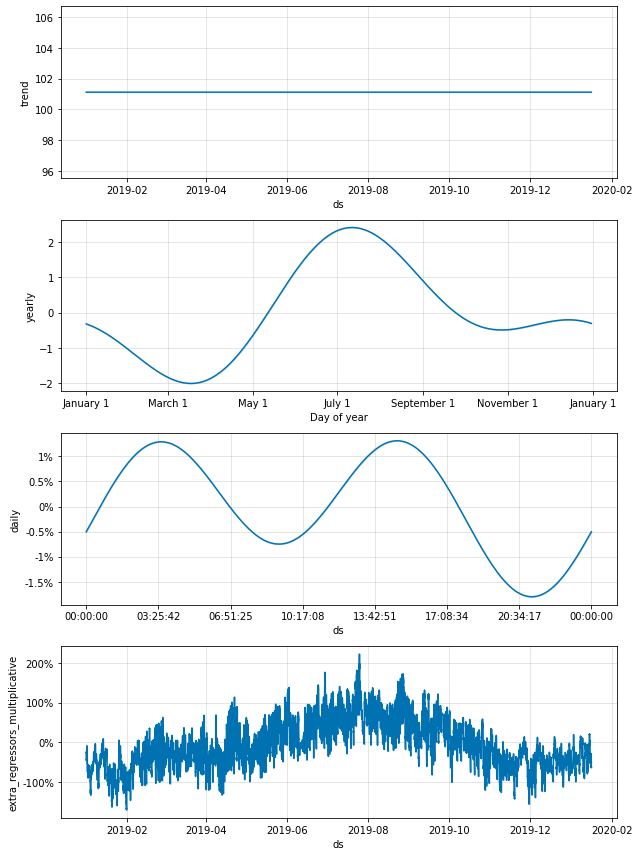

In [17]:
forecast_opt = m_opt.predict(df_test)
fig3 = m_opt.plot_components(forecast_opt)

---

## Conclusion

Findings:
 * Bayesian optimised parameters
   * it's notable that `yearly_prior` has converged to the maximum limit (2) and `dp_prior` plus `hum_prior` converged to the lower limit (-2)
 * Components
   * yearly and daily seasonalities appear overfitted to me
     * I would expect a smooth cycle with a single maximum and a single minimum
   * there may be some seasonality present in the extra regressors
     * check for seasonality in performance of the model
 * Diagnostics
   * the Bayesian optimised model is superior to the simple model
   * the Bayesian optimised model is comparable to the partially optimised grid search model
 * Number of model evaluations
   * unfortunately, we cannot make a good comparison between the R grid search and the Bayesian optimisation
     * I used a more restricted parameter range in the R grid search
     * a comparable grid would be [0.01, 0.1, 0, 1, 10, 100] meaning potentially 625 (5 ** 4) model evaluations for these 4 continuous parameters
     * this compares well with the 30 model evaluations performed for Bayesian optimisation
   * a comparable random search may not give better results than Bayesian optimisation

It's disappointing that the Bayesian optimised model has worse performance than the 
[simple exponential smoothing baseline model](https://github.com/makeyourownmaker/CambridgeTemperatureModel#one-step-ahead-baselines) :-(

Future work could include:
 * Plot individual affect of each regressor as done in this [weather related prophet notebook](https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb)
 * Consider deseasonalising the regressors
 * Explore addition of lagged regressors
 * Expand horizon to 2 hours
   * limited to 1 hour here to reduce compute time
 * Plot optimisation progress
   * the bayes_opt package does not include any built-in plots
   * plots could show if there are any unexplored areas of parameter space
 * Cross-validation would benefit from being 
[parallelised](https://facebook.github.io/prophet/docs/diagnostics.html#parallelizing-cross-validation)

In conclusion, the Bayesian optimised model is much improved but the possible seasonality in the regressors needs further investigation.

---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

In [18]:
notebook = "BayesOptProphetHyperparameters.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}

[NbConvertApp] Converting notebook BayesOptProphetHyperparameters.ipynb to python
[NbConvertApp] Writing 18396 bytes to BayesOptProphetHyperparameters.py
[NbConvertApp] Converting notebook BayesOptProphetHyperparameters.ipynb to markdown
[NbConvertApp] Support files will be in BayesOptProphetHyperparameters_files/
[NbConvertApp] Making directory BayesOptProphetHyperparameters_files
[NbConvertApp] Making directory BayesOptProphetHyperparameters_files
[NbConvertApp] Writing 151384 bytes to BayesOptProphetHyperparameters.md
[NbConvertApp] Converting notebook BayesOptProphetHyperparameters.ipynb to html
[NbConvertApp] Writing 910968 bytes to BayesOptProphetHyperparameters.html


---

## Metadata

Python and Jupyter versions plus modules imported and their version strings.
This is the poor man's python equivalent of R's [`sessionInfo()`](https://stat.ethz.ch/R-manual/R-patched/library/utils/html/sessionInfo.html).

Code for imported modules and versions adapted from this [stackoverflow answer](https://stackoverflow.com/a/49199019/100129).  There are simpler alternatives,
such as [watermark](https://github.com/rasbt/watermark),
but they all require installation.

In [19]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/local/opt/python@3.8/bin/python3.8
3.8.6 (default, Oct  8 2020, 14:17:19) 
[Clang 10.0.0 (clang-1000.11.45.5)]

IPython version:
7.19.0


In [20]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
            "bayes_opt": "bayesian-optimization",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns=['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
pandas,1.0.5
numpy,1.19.1
notebook,6.1.6
matplotlib,3.3.1
fbprophet,0.7.1
bayesian-optimization,1.2.0


In [21]:
!date

Thu Jan 14 22:17:10 GMT 2021
